In [1]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import sys
import anndata as an
import scanpy as sp
import h5py

sys.path.append('../src')
sys.path.append('../tests')

from lightning_train import DataModule, generate_trainer
from data import *
from model import *
from testing import *

from pytorch_lightning.loggers import WandbLogger
from torchmetrics.functional import *

import pandas as pd
from scipy.sparse import csr_matrix
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from functools import partial
import torchmetrics.functional as f
from torchmetrics import Metric
import torchmetrics 

In [2]:
data = an.read_h5ad('../data/pancreas/pancreas.h5ad')
data

/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [24]:
data.obs

,celltype,sample,n_genes,batch,n_counts,louvain
index,,,,,,
human1_lib1.final_cell_0001-0,acinar,Baron,3526,0,2.241100e+04,2
human1_lib1.final_cell_0002-0,acinar,Baron,4201,0,2.794900e+04,2
human1_lib1.final_cell_0003-0,acinar,Baron,2119,0,1.689200e+04,2
human1_lib1.final_cell_0004-0,acinar,Baron,2956,0,1.929900e+04,2
human1_lib1.final_cell_0005-0,acinar,Baron,2715,0,1.506700e+04,2
...,...,...,...,...,...,...
reads.29499-3,ductal,Wang,19950,3,1.056558e+06,10
reads.29500-3,ductal,Wang,19950,3,9.926309e+05,10
reads.29501-3,beta,Wang,19950,3,1.751338e+06,10


In [23]:
# labels = data.obs[data.obs['celltype'] != 'unclear' & data.obs['celltype'] != 'unclassified']

labels = pd.DataFrame(data.obs['celltype'].astype(str)).reset_index()

labels.index.name = 'cell'
labels = labels[(labels['celltype'] != 'unclear') & (labels['celltype'] != 'unclassified')].reset_index()

labels.to_csv('../data/pancreas/labels.csv')

In [56]:
import plotly.express as px 

px.scatter(x=data.obsm['X_umap'][:, 0], y=data.obsm['X_umap'][:, 1], color=data.obs['celltype'])

wandb: Network error (ReadTimeout), entering retry loop.
wandb: ERROR Error while calling W&B API: dial tcp 34.68.206.48:3307: connect: connection refused (<Response [500]>)
wandb: ERROR Error while calling W&B API: dial tcp 34.68.206.48:3307: connect: connection refused (<Response [500]>)
wandb: Network error (ReadTimeout), entering retry loop.


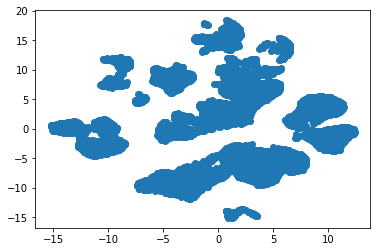

In [55]:
import matplotlib.pyplot as plt

plt.scatter(x=data.obsm['X_umap'][:, 0], y=data.obsm['X_umap'][:, 1])

Now that we know all the labels are the same, we can subset the samples we'd like to train on and train a model

In [40]:
common_labels = []
for i in range(4):
    labels = data.obs.reset_index(drop=True) # make index numeric 
    labels = labels[labels['batch'] == str(i)]
    labels.index.name = 'cell'
    common_labels.append(labels['celltype'].unique().categories)
    labels.to_csv(f'../data/pancreas/batch_{i}_labels.csv', index=True)

# Test refgenes to make sure this code is buggy .. 

In [31]:
datamodule = DataModule(
    datafiles=['../data/pancreas/pancreas.h5ad'],
    labelfiles=['../data/pancreas/batch_0_labels.csv'],
    class_label='celltype',
    index_col='cell',
    assume_numeric_label=False,
)

datamodule.prepare_data()
datamodule.setup()

model = TabNetLightning(
    input_dim=datamodule.num_features,
    output_dim=datamodule.num_labels,
)

assume_numeric_label=False, using sklearn.preprocessing.LabelEncoder and encoding target variables.
Creating train/val/test DataLoaders...


/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


Done, continuing to training.
Calculating weights
Initializing network
Initializing explain matrix


In [32]:
wandb_logger = WandbLogger(
    project=f"Pancreas Model",
    name='Local, Default Settings'
)

trainer = pl.Trainer(
    logger=wandb_logger,
    max_epochs=200,
)

trainer.fit(model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
wandb: Currently logged in as: jlehrer1 (use `wandb login --relogin` to force relogin)



  | Name    | Type   | Params
-----------------------------------
0 | network | TabNet | 167 K 
-----------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Median f1 score is 0.0 for epoch=0


/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:219: UserWarning: You called `self.log('val_confusion_matrix', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*a

Training: 0it [00:00, ?it/s]

/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:219: UserWarning: You called `self.log('train_confusion_matrix', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

/Users/julian/Documents/Projects/SIMS/notebooks/../src/model.py:208: RuntimeWarning: invalid value encountered in true_divide
  f1s = 2*(precision * recall) / (precision + recall)


Median f1 score is 0.0 for epoch=0


/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [77]:
trainer.validate(model, datamodule=datamodule)

Validating: 0it [00:00, ?it/s]

Median f1 score is 0.8883735312306741 for epoch=165
Validation F1-scores are [0.93638677 0.94017094 0.96624473 0.96119403 0.89795918 0.95852535
 0.93069307 0.         0.84210526 0.         0.         0.87878788
 0.         0.        ]
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.9416569471359253,
 'val_precision': 0.9416569471359253,
 'val_recall': 0.9416569471359253}
--------------------------------------------------------------------------------


[{'val_accuracy': 0.9416569471359253,
  'val_precision': 0.9416569471359253,
  'val_recall': 0.9416569471359253}]

In [35]:
t1 = data.obs[data.obs['batch'] == '0']
t2 = data.obs[data.obs['batch'] == '1']

In [44]:
t1['celltype'].unique().categories

Index(['MHC class II', 'PSC', 'acinar', 'activated_stellate', 'alpha', 'beta',
       'co-expression', 'delta', 'dropped', 'ductal', 'endothelial', 'epsilon',
       'gamma', 'macrophage', 'mast', 'mesenchymal', 'mesenchyme',
       'not applicable', 'quiescent_stellate', 'schwann', 't_cell',
       'unclassified', 'unclassified endocrine', 'unclear'],
      dtype='object')

In [45]:
t2['celltype'].unique().categories == t1['celltype'].unique().categories

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])